In [1]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import classification_report 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

from evc import BayesianEvaluation # Importa a library do Prof Verri

from cancer_estimator_model import datasets

# Carregar o dataset 
df = datasets.get_integrated_dataset()
display(df.head(10).T)
df.info()

,0,1,2,3,4,5,6,7,8,9
AGE,69.0,74.0,59.0,63.0,63.0,75.0,52.0,51.0,68.0,53.0
SMOKING,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
YELLOW_FINGERS,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
ANXIETY,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
PEER_PRESSURE,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
CHRONIC_DISEASE,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
FATIGUE,1,1,1,0,0,1,1,1,1,0
ALLERGY,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
WHEEZING,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
ALCOHOL_CONSUMING,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318109 entries, 0 to 318108
Data columns (total 55 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGE                    1309 non-null    float64
 1   SMOKING                1309 non-null    float64
 2   YELLOW_FINGERS         1309 non-null    float64
 3   ANXIETY                309 non-null     float64
 4   PEER_PRESSURE          309 non-null     float64
 5   CHRONIC_DISEASE        309 non-null     float64
 6   FATIGUE                318109 non-null  int64  
 7   ALLERGY                309 non-null     float64
 8   WHEEZING               1309 non-null    float64
 9   ALCOHOL_CONSUMING      309 non-null     float64
 10  COUGHING               318109 non-null  int64  
 11  SHORTNESS_OF_BREATH    318109 non-null  int64  
 12  SWALLOWING_DIFFICULTY  318109 non-null  int64  
 13  CHEST_PAIN             318109 non-null  int64  
 14  LUNG_CANCER_RISK       1309 non-null

In [3]:
# Dividir o conjunto de dados em features (X) e variável alvo (y)
X = df.drop(columns=['LUNG_CANCER_RISK','COUNTRY'])
y = df['LUNG_CANCER_RISK']

# Tratar valores ausentes nas colunas categóricas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    X[col].fillna('missing', inplace=True)

# Dividir o conjunto de dados em train and test
X_train = X[X.SOURCE != 3]  # dropa os dados que tem a source 3 (dataset covid)
X_test = X[X.SOURCE == 3]   # coloca somente os dados com a source 3 no teste (dataset covid)
y_train = y[X.SOURCE != 3].astype(float)  # dropa os dados que tem a source 3 (dataset covid) na target


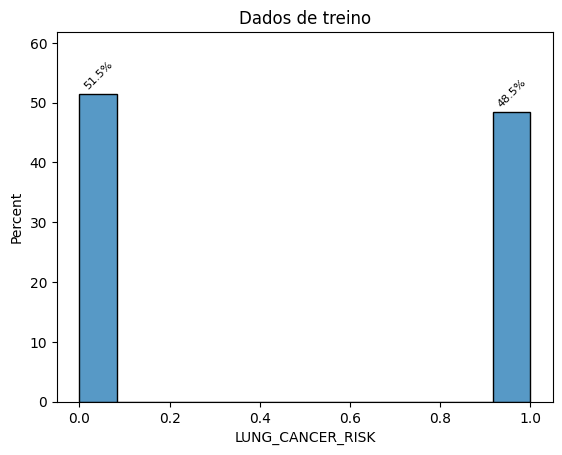

In [4]:
def plot_y_distribution(y,title=None):
    # Criando distribuição da variável resposta estimada
    ax = sns.histplot(y, stat='percent')
    
    
    # add annotations
    for c in ax.containers:
    
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
    
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=8, rotation=45, padding=2)
        
        ax.margins(y=0.2)

     # Add title, if done
    if title:
        plt.title(title)
    plt.show()
plot_y_distribution(y_train,title='Dados de treino')

In [5]:
# Cross validation with catboost regression

In [6]:
# Criar o modelo CatBoostRegressor
model_cat = CatBoostRegressor(
    iterations=500, 
    depth=6,
    eval_metric="RMSE",  # Métrica apropriada para regressão
    learning_rate=0.1, 
    cat_features=categorical_cols,  # Passar as colunas categóricas
    verbose=0     
)

# Definir um limiar de decisão para converter previsões contínuas em classes
decision_threshold = 0.6

def custom_scoring(y_true, y_pred):
    y_pred_class = (y_pred >= decision_threshold).astype(int)  # Converter previsões contínuas para classes com base no limiar
    report = classification_report(y_true, y_pred_class)
    #cm = confusion_matrix(y_true, y_pred_class)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #print(report)
    #disp.plot(cmap=plt.cm.Blues)
    #plt.show()
    return f1_score(y_true, y_pred_class)

# Criar o objeto de validação cruzada estratificada
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)


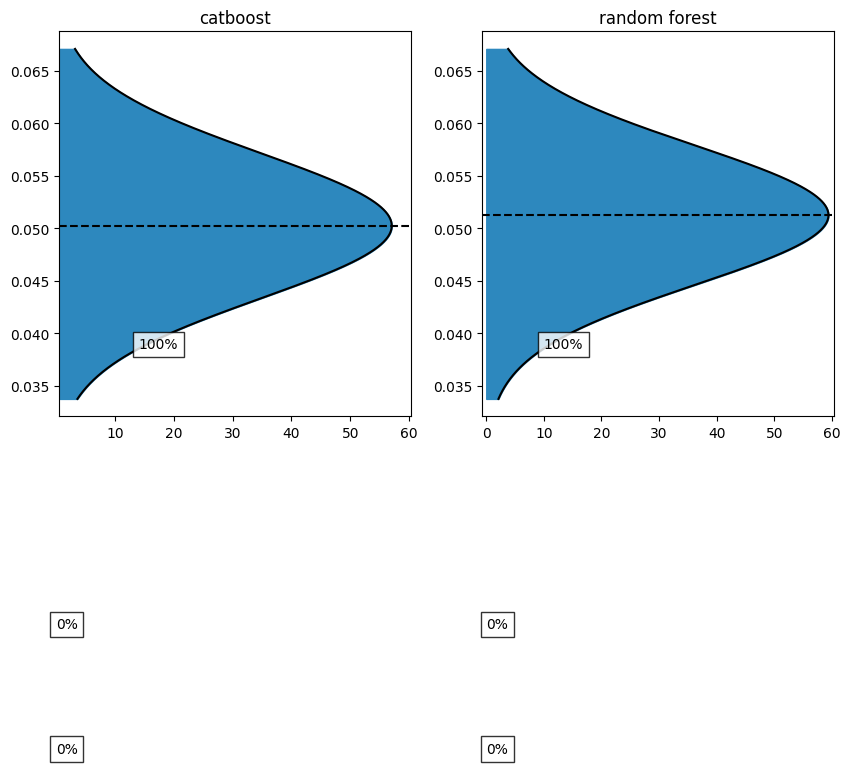

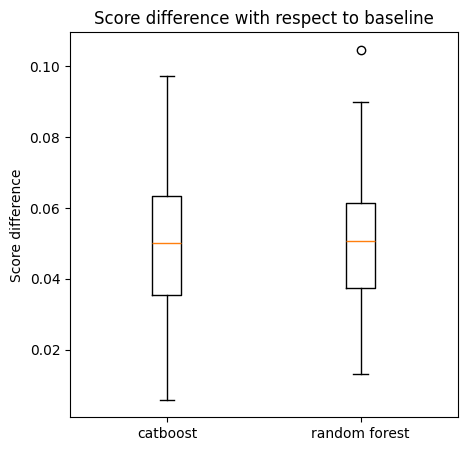

In [7]:
# Create baseline pipeline

baseline = Pipeline([
    ('dt', DecisionTreeClassifier(max_depth=2, random_state=0))
])

competitors = [
    ('catboost', Pipeline([
        ('catboost', model_cat)
    ])),
    ('random forest', Pipeline([
        ('random forest', RandomForestClassifier(n_estimators=10, random_state=0))
    ])) 
]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

baseline_score = cross_val_score(baseline, X_train, y_train, cv=cv, scoring=make_scorer(custom_scoring))
competitors_score = [
        (name, cross_val_score(competitor, X_train, y_train, cv=cv,
            scoring=make_scorer(custom_scoring))) for name, competitor in competitors]

be = BayesianEvaluation(baseline_score, rope=0.01)

be.plot(competitors_score)

# Now plot a boxplot of the difference of the scores.

scores = [score - baseline_score for name, score in competitors_score]
names = [name for name, score in competitors_score]

from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.boxplot(scores)
ax.set_xticklabels(names)
ax.set_ylabel('Score difference')
ax.set_title('Score difference with respect to baseline')

plt.show()

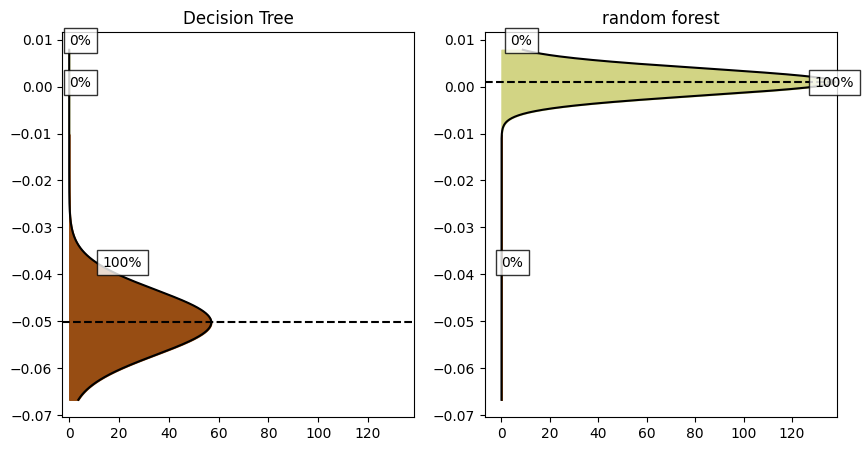

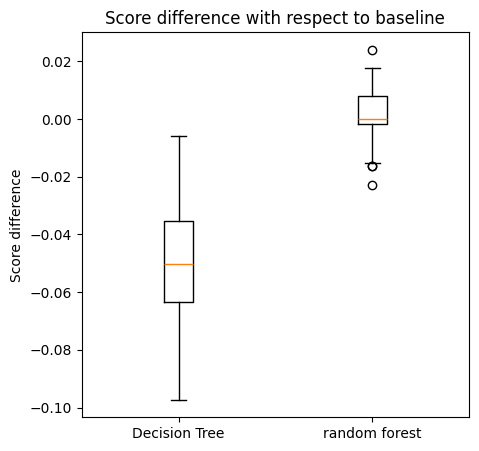

In [8]:
# Create baseline pipeline

baseline = Pipeline([
        ('catboost', model_cat)
    ])


competitors = [
    ('Decision Tree', Pipeline([
        ('Decision Tree', DecisionTreeClassifier(max_depth=2, random_state=0))
    ])),
    ('random forest', Pipeline([
        ('random forest', RandomForestClassifier(n_estimators=10, random_state=0))
    ])) 
]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

baseline_score = cross_val_score(baseline, X_train, y_train, cv=cv, scoring=make_scorer(custom_scoring))
competitors_score = [
        (name, cross_val_score(competitor, X_train, y_train, cv=cv,
            scoring=make_scorer(custom_scoring))) for name, competitor in competitors]

be = BayesianEvaluation(baseline_score, rope=0.01)

be.plot(competitors_score)

# Now plot a boxplot of the difference of the scores.

scores = [score - baseline_score for name, score in competitors_score]
names = [name for name, score in competitors_score]

from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.boxplot(scores)
ax.set_xticklabels(names)
ax.set_ylabel('Score difference')
ax.set_title('Score difference with respect to baseline')

plt.show()

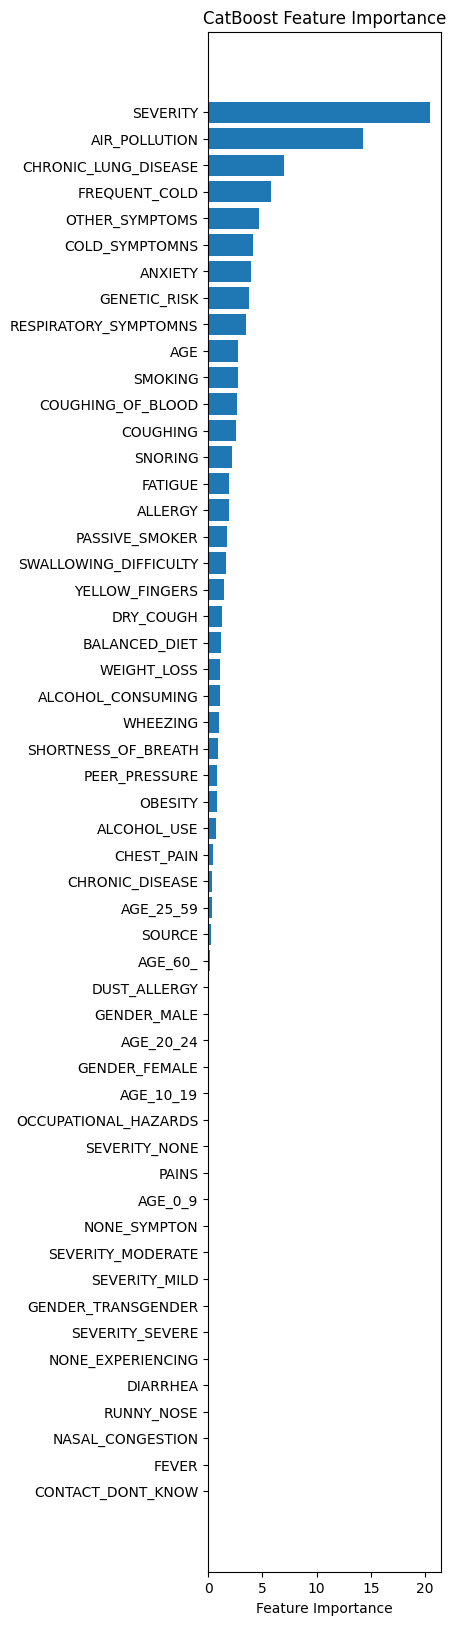

In [9]:
# plot feature importance
# train with all data to calculate proper feature importance
# model_cat.fit(X_train, y_train)
feature_importance = model_cat.get_feature_importance(type='FeatureImportance')
feature_names = model_cat.feature_names_
sorted_idx = feature_importance.argsort()

plt.figure(figsize=(8,15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()


<Axes: >

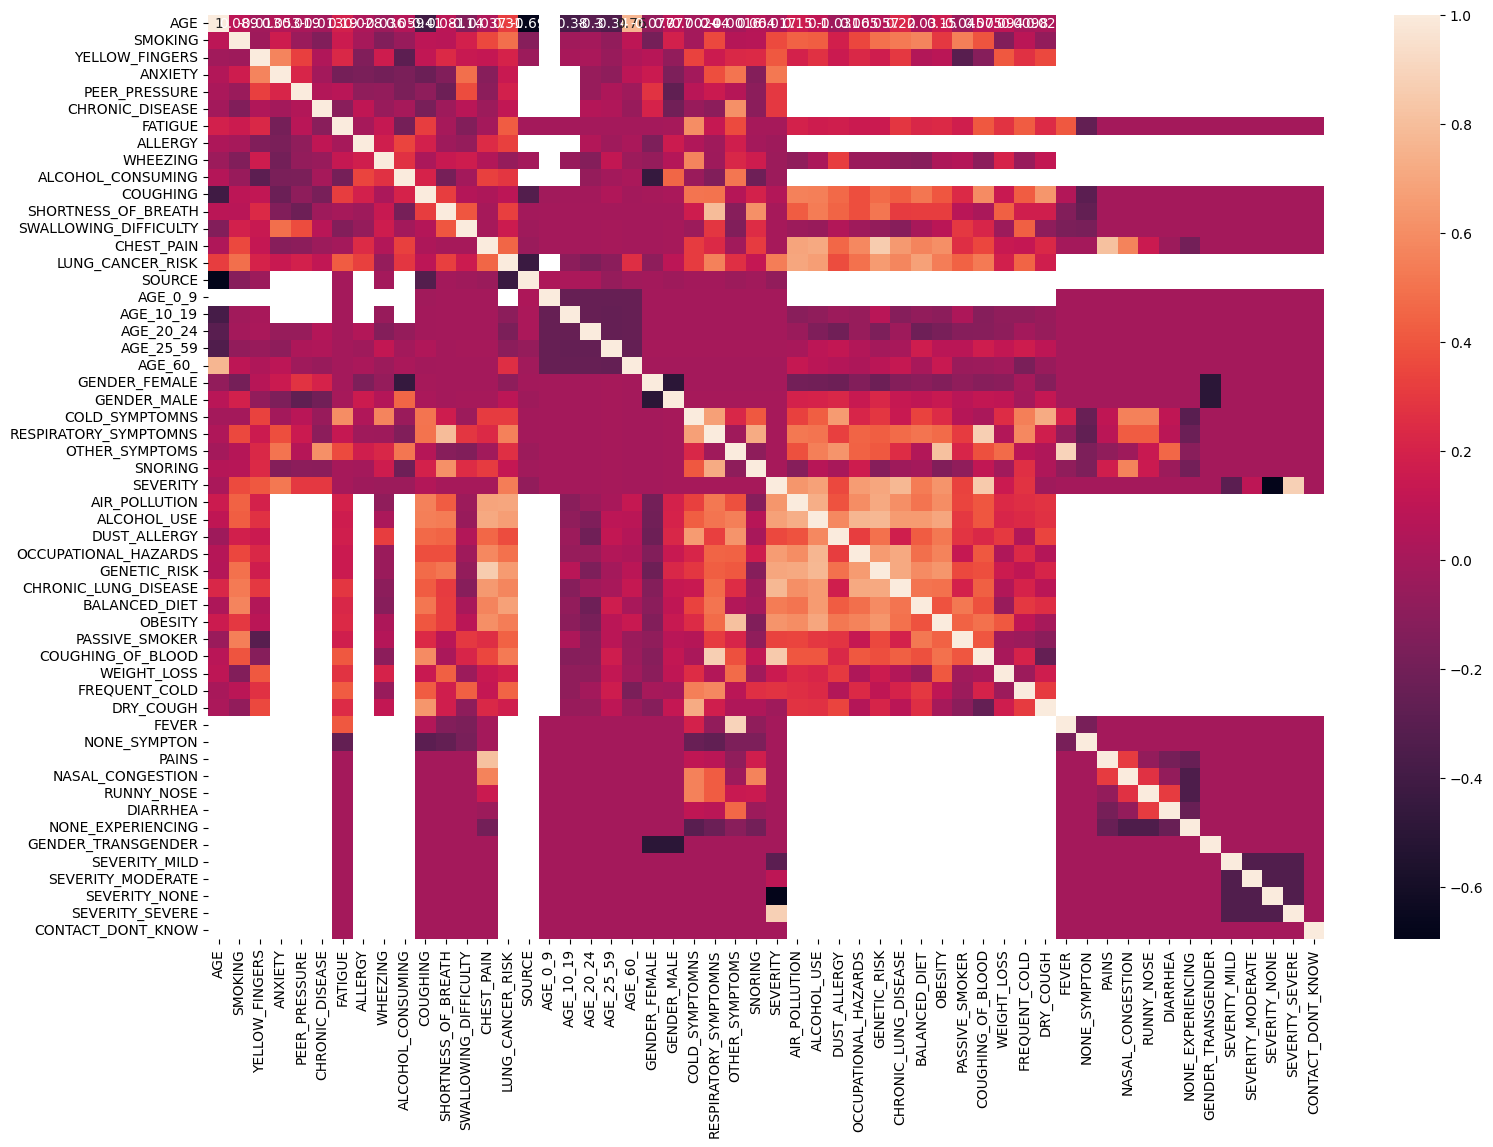

In [10]:
# Correlação das features

df_sem_country = df.drop(columns=['COUNTRY'])
cor = df_sem_country.corr()

plt.figure(figsize = (18,12))
sns.heatmap(cor, annot = True)

In [11]:
# pelo feature importance e pela correlação, sugere-se dropar as seguintes features:
# AIR_POLLUTION; DUST_ALLERGY; GENETIC_RISK; BALANCED_DIET; PASSIVE_SMOKER; WEIGHT_LOSS; DRY_COUGH; NONE_SYMPTON; NASAL_CONGESTION; DIARRHEA; 
# GENDER_TRANSGENDER; SEVERITY_MODERATE; SEVERITY_SEVERE; CONTACT_DONT_KNOW.

# MODELO 2
# ========

df2 =  df.drop(columns=['COUNTRY','AIR_POLLUTION', 'DUST_ALLERGY', 'GENETIC_RISK', 'BALANCED_DIET', 'PASSIVE_SMOKER', 'WEIGHT_LOSS', 
                        'DRY_COUGH', 'NONE_SYMPTON', 'NASAL_CONGESTION', 'DIARRHEA', 'GENDER_TRANSGENDER', 'SEVERITY_MODERATE', 'SEVERITY_SEVERE',
                        'CONTACT_DONT_KNOW'])

# Dividir o conjunto de dados em features (X) e variável alvo (y)
X2 = df2.drop(columns=['LUNG_CANCER_RISK'])
y2 = df2['LUNG_CANCER_RISK']

# Tratar valores ausentes nas colunas categóricas
categorical_cols = X2.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    X2[col].fillna('missing', inplace=True)

# Dividir o conjunto de dados em train and test
X2_train = X2[X2.SOURCE != 3]  # dropa os dados que tem a source 3 (dataset covid)
X2_test = X2[X2.SOURCE == 3]   # coloca somente os dados com a source 3 no teste (dataset covid)
y2_train = y2[X2.SOURCE != 3].astype(float)  # dropa os dados que tem a source 3 (dataset covid) na target

# Criar o modelo CatBoostRegressor
model_cat2 = CatBoostRegressor(
    iterations=500, 
    depth=6,
    eval_metric="RMSE",  # Métrica apropriada para regressão
    learning_rate=0.1, 
    cat_features=categorical_cols,  # Passar as colunas categóricas
    verbose=0
)

# Definir um limiar de decisão para converter previsões contínuas em classes
decision_threshold2 = 0.6

def custom_scoring(y_true, y_pred):
    y_pred_class = (y_pred >= decision_threshold).astype(int)  # Converter previsões contínuas para classes com base no limiar
    report = classification_report(y_true, y_pred_class)
    #cm = confusion_matrix(y_true, y_pred_class)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #print(report)
    #disp.plot(cmap=plt.cm.Blues)
    #plt.show()
    return f1_score(y_true, y_pred_class)

# Criar o objeto de validação cruzada estratificada
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)


# Criar outro modelo dropando além destas features, as seguintes:
# RUNNY_NOSE; FEVER; NONE_EXPERIENCING; SEVERITY_NONE;

# MODELO 3
# ========

df3 =  df2.drop(columns=['RUNNY_NOSE','FEVER','NONE_EXPERIENCING','SEVERITY_NONE'])

# Dividir o conjunto de dados em features (X) e variável alvo (y)
X3 = df3.drop(columns=['LUNG_CANCER_RISK'])
y3 = df3['LUNG_CANCER_RISK']

# Tratar valores ausentes nas colunas categóricas
categorical_cols = X3.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    X3[col].fillna('missing', inplace=True)

# Dividir o conjunto de dados em train and test
X3_train = X3[X3.SOURCE != 3]  # dropa os dados que tem a source 3 (dataset covid)
X3_test = X3[X3.SOURCE == 3]   # coloca somente os dados com a source 3 no teste (dataset covid)
y3_train = y3[X3.SOURCE != 3].astype(float)  # dropa os dados que tem a source 3 (dataset covid) na target

# Criar o modelo CatBoostRegressor
model_cat3 = CatBoostRegressor(
    iterations=500, 
    depth=6,
    eval_metric="RMSE",  # Métrica apropriada para regressão
    learning_rate=0.1, 
    cat_features=categorical_cols,  # Passar as colunas categóricas
    verbose=0
)

# Definir um limiar de decisão para converter previsões contínuas em classes
decision_threshold3 = 0.7

def custom_scoring(y_true, y_pred):
    y_pred_class = (y_pred >= decision_threshold).astype(int)  # Converter previsões contínuas para classes com base no limiar
    report = classification_report(y_true, y_pred_class)
    #cm = confusion_matrix(y_true, y_pred_class)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #print(report)
    #disp.plot(cmap=plt.cm.Blues)
    #plt.show()
    return f1_score(y_true, y_pred_class)

# Criar o objeto de validação cruzada estratificada
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

#MODELO 4 - DROPA AS VARIÁVEIS MAIS IMPORTANTES
#==============================================

# Testa a viabilidade do modelo. Dropando as features mais importantes, o modelo deve ficar pior.

df4 =  df.drop(columns=['COUNTRY', 'SEVERITY', 'AIR_POLLUTION', 'CHRONIC_LUNG_DISEASE', 'FREQUENT_COLD', 'OTHER_SYMPTOMS', 'COLD_SYMPTOMNS', 'ANXIETY', 
                       'GENETIC_RISK', 'RESPIRATORY_SYMPTOMNS'])

# Dividir o conjunto de dados em features (X) e variável alvo (y)
X4 = df4.drop(columns=['LUNG_CANCER_RISK'])
y4 = df4['LUNG_CANCER_RISK']

# Tratar valores ausentes nas colunas categóricas
categorical_cols = X4.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    X4[col].fillna('missing', inplace=True)

# Dividir o conjunto de dados em train and test
X4_train = X4[X4.SOURCE != 3]  # dropa os dados que tem a source 3 (dataset covid)
X4_test = X4[X4.SOURCE == 3]   # coloca somente os dados com a source 3 no teste (dataset covid)
y4_train = y4[X4.SOURCE != 3].astype(float)  # dropa os dados que tem a source 3 (dataset covid) na target

# Criar o modelo CatBoostRegressor
model_cat4 = CatBoostRegressor(
    iterations=500, 
    depth=6,
    eval_metric="RMSE",  # Métrica apropriada para regressão
    learning_rate=0.1, 
    cat_features=categorical_cols,  # Passar as colunas categóricas
    verbose=0
)

# Definir um limiar de decisão para converter previsões contínuas em classes
decision_threshold4 = 0.6

def custom_scoring(y_true, y_pred):
    y_pred_class = (y_pred >= decision_threshold).astype(int)  # Converter previsões contínuas para classes com base no limiar
    report = classification_report(y_true, y_pred_class)
    #cm = confusion_matrix(y_true, y_pred_class)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #print(report)
    #disp.plot(cmap=plt.cm.Blues)
    #plt.show()
    return f1_score(y_true, y_pred_class)

# Criar o objeto de validação cruzada estratificada
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

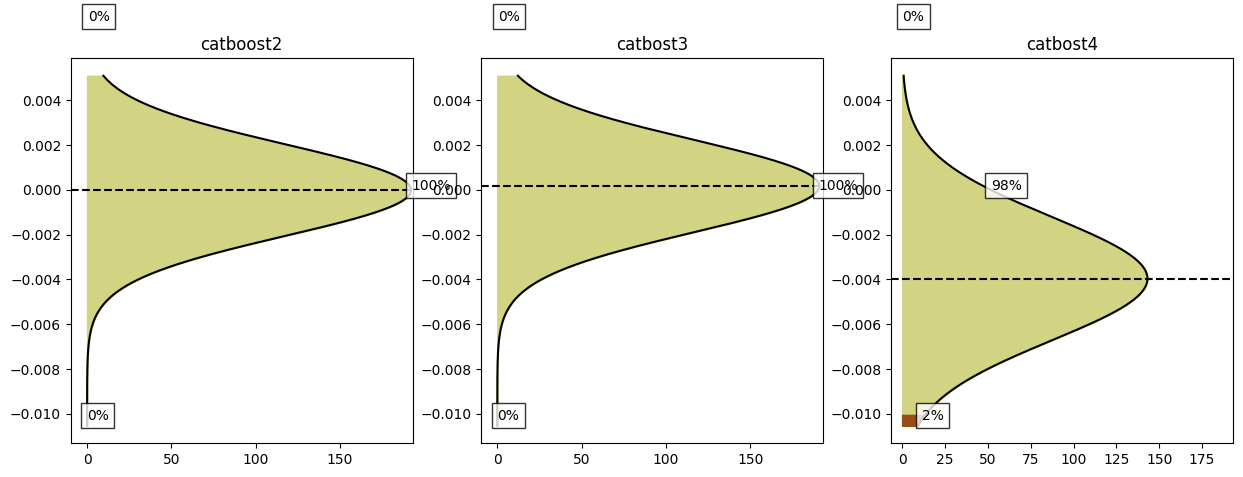

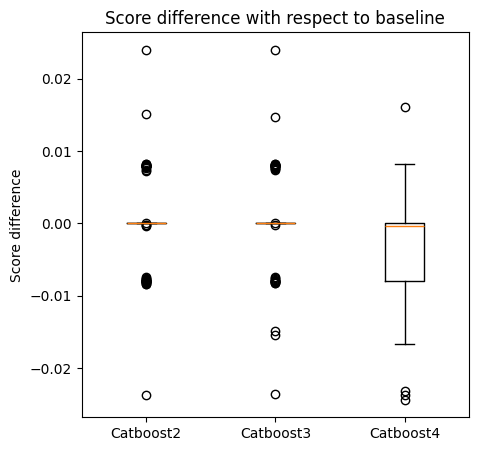

In [12]:
# Create baseline pipeline

baseline = Pipeline([
        ('catboost', model_cat)
    ])


competitors = [
    ('catboost2', Pipeline([
        ('catboost2', model_cat2)
    ])),
    ('catboost3', Pipeline([
        ('catboost3', model_cat3)
    ])),
    ('catboost4', Pipeline([
        ('catboost4', model_cat3)
    ]))
]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

baseline_score = cross_val_score(baseline, X_train, y_train, cv=cv, scoring=make_scorer(custom_scoring))
competitors_score = [('catboost2', cross_val_score(model_cat2, X2_train, y2_train, cv=cv,
            scoring=make_scorer(custom_scoring))),
                   ('catbost3', cross_val_score(model_cat3, X3_train, y3_train, cv=cv,
            scoring=make_scorer(custom_scoring))),
                ('catbost4', cross_val_score(model_cat4, X4_train, y4_train, cv=cv,
            scoring=make_scorer(custom_scoring)))]
                                        
be = BayesianEvaluation(baseline_score, rope=0.01)

be.plot(competitors_score)

# Now plot a boxplot of the difference of the scores.

scores = [score - baseline_score for name, score in competitors_score]
names = ['Catboost2','Catboost3', 'Catboost4']

from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.boxplot(scores)
ax.set_xticklabels(names)
ax.set_ylabel('Score difference')
ax.set_title('Score difference with respect to baseline')

plt.show()

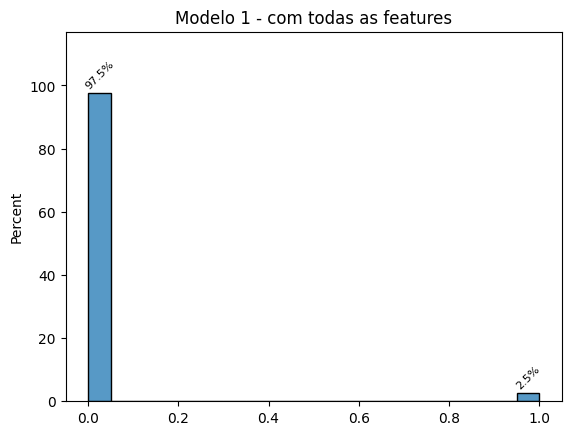

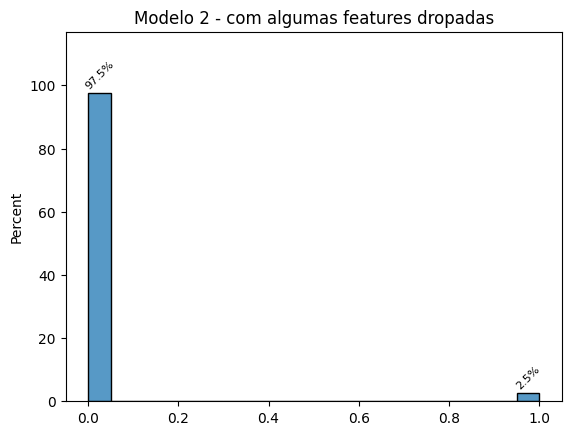

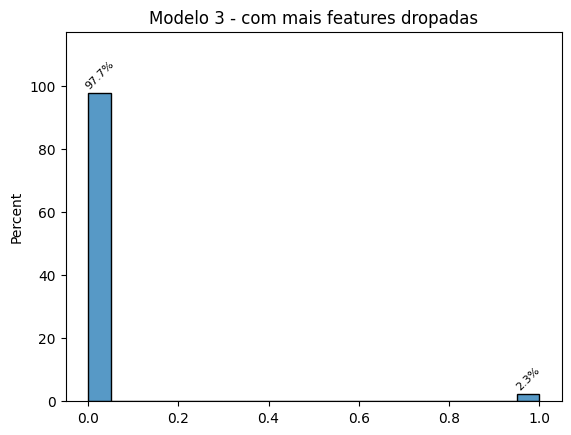

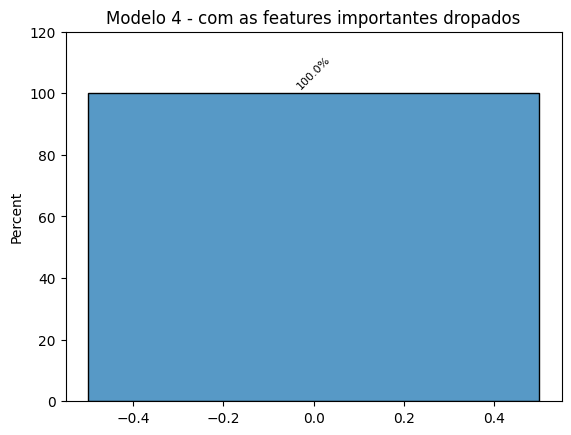

In [13]:
# Ajustar o modelo aos dados de treino completos (modelo catboost)
model_cat.fit(X_train, y_train)

# Fazer a predição no conjunto de dados de teste
y_pred = model_cat.predict(X_test)
y_pred_class = (y_pred >= decision_threshold).astype(int)  # Converter previsões contínuas para classes

plot_y_distribution(y_pred_class, title='Modelo 1 - com todas as features')


# Modelo 2
model_cat2.fit(X2_train, y2_train)

# Fazer a predição no conjunto de dados de teste
y_pred2 = model_cat2.predict(X2_test)
y_pred2_class = (y_pred2 >= decision_threshold2).astype(int)  # Converter previsões contínuas para classes

plot_y_distribution(y_pred2_class, title='Modelo 2 - com algumas features dropadas')

# Modelo 3
model_cat3.fit(X3_train, y3_train)

# Fazer a predição no conjunto de dados de teste
y_pred3 = model_cat3.predict(X3_test)
y_pred3_class = (y_pred3 >= decision_threshold3).astype(int)  # Converter previsões contínuas para classes

plot_y_distribution(y_pred3_class, title='Modelo 3 - com mais features dropadas')

# Modelo 4
model_cat4.fit(X4_train, y4_train)

# Fazer a predição no conjunto de dados de teste
y_pred4 = model_cat4.predict(X4_test)
y_pred4_class = (y_pred4 >= decision_threshold4).astype(int)  # Converter previsões contínuas para classes

plot_y_distribution(y_pred4_class, title='Modelo 4 - com as features importantes dropados')





In [14]:
# Observa-se que o Modelo 4 não fornece bons resultados (o que é obvio, pois foram excluidas as features de maior importância).
# Os modelos 1,2 e 3 são equivalentes, logo, pode-se optar pelo modelo 3 que possui menos features.